In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import nilearn
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_modules, level_dictionary, level_from_tree
from tree_features import T_from_level, adj_matrices_from_level, brain_maps_network_measure, threshold_based_similarity_external, density_threshold
from tree_features import tree_dictionary, get_module_vol, cross_modularity, add_gamma_to_lvl_dict, threshold_based_similarity, modularity, network_from_level
from tree_features import measure_betweenness, measure_strength, measure_clustering_coef, measure_pathlength, get_atlas_rois_from_mask, similarity_mean_level
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import networkx as nx
import abagen

## Connectome loading

In [22]:
project_path = "/workspaces/bha2"
sc_group = load_data(os.path.join(project_path, "data", "raw", "sc"))
fc_group = load_data(os.path.join(project_path, "data", "raw", "fc"))

In [23]:
fcm, scm = connectome_average(fc_group, sc_group)
print(fcm.shape)
print(scm.shape)

(1795, 1795)
(1795, 1795)


In [32]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
zero_rows_sc

array([ 124,  623, 1360, 1402, 1523, 1547])

In [25]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
scm_nonzero = np.delete(scm, zero_rows_sc, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows_sc, axis=1)
fcm_nonzero = np.delete(fcm, zero_rows_sc, axis=0)
fcm_nonzero = np.delete(fcm_nonzero, zero_rows_sc, axis=1)
print(fcm_nonzero.shape)
print(scm_nonzero.shape)

(1789, 1789)
(1789, 1789)


In [26]:

density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
zero_rows_fc


array([  68,  134,  170,  249,  279,  308,  473,  496, 1332, 1436, 1441,
       1487, 1491, 1605, 1693, 1704, 1724, 1738, 1770])

In [27]:

#remove the element zero_rows from fcm and scm
fcm_thr_nonzero = np.delete(fcm_thr, zero_rows_fc, axis=0)
fcm_thr_nonzero = np.delete(fcm_thr_nonzero, zero_rows_fc, axis=1)
scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=1)
fcm_bin = np.where(fcm_thr_nonzero > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 
print(fcm_bin.shape)
print(scm_bin.shape)

(1770, 1770)
(1770, 1770)


Text(0.5, 1.0, 'Structural connectivity matrix')

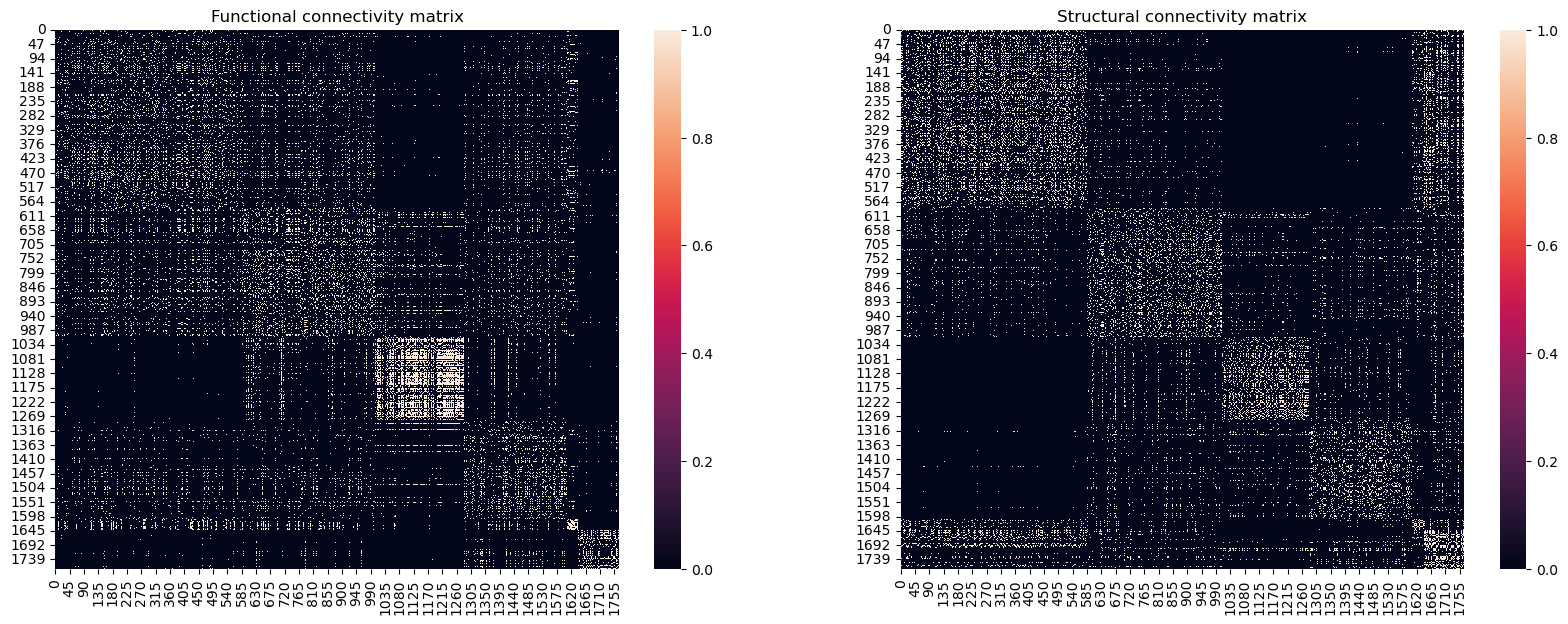

In [28]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_bin, ax=ax[0])
ax[0].set_title("Functional connectivity matrix")
sns.heatmap(scm_bin, ax=ax[1])
ax[1].set_title("Structural connectivity matrix")

## Generating trees

In [29]:
tree_folder = "tree_network_measures"
tree_min = 10
tree_max = 1500
#get the rows with all the elements with zero

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    json.dump(t_dict, open(os.path.join(project_path, "data", "results", "tree_equaldensity_bin_full_g_" + str(round(g, 2)) + ".json"), "w"))


## Crossmodularity

In [33]:
lvlmin = 10
lvlmax = 100
crossmod_gammas = np.empty((lvlmax - lvlmin, 1))
mod_sc_gammas = np.empty((lvlmax - lvlmin, 1))
mod_fc_gammas = np.empty((lvlmax - lvlmin, 1))
sim_gammas = np.empty((lvlmax - lvlmin, 1))

for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "data", "results",
        "tree_equaldensity_bin_full_g_" + str(round(g, 2)) + ".json")).read())
    crossmod = []
    mod_sc = []
    mod_fc = []
    sim_lvl = []
    for l in range(lvlmin,lvlmax):
        level, labels = level_from_tree(tree, l)
        T = T_from_level(level)
        sim = similarity_mean_level(fcm_bin, scm_bin, level)
        mod_sc_lvl = modularity(scm_bin, T)
        mod_fc_lvl = modularity(fcm_bin, T)
        mod_sc.append(mod_sc_lvl)
        mod_fc.append(mod_fc_lvl)
        sim_lvl.append(sim)
        c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
        crossmod.append(c)
    crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
    mod_sc_gammas = np.hstack((mod_sc_gammas, np.array(mod_sc).reshape(-1,1)))
    mod_fc_gammas = np.hstack((mod_fc_gammas, np.array(mod_fc).reshape(-1,1)))
    sim_gammas = np.hstack((sim_gammas, np.array(sim_lvl).reshape(-1,1)))

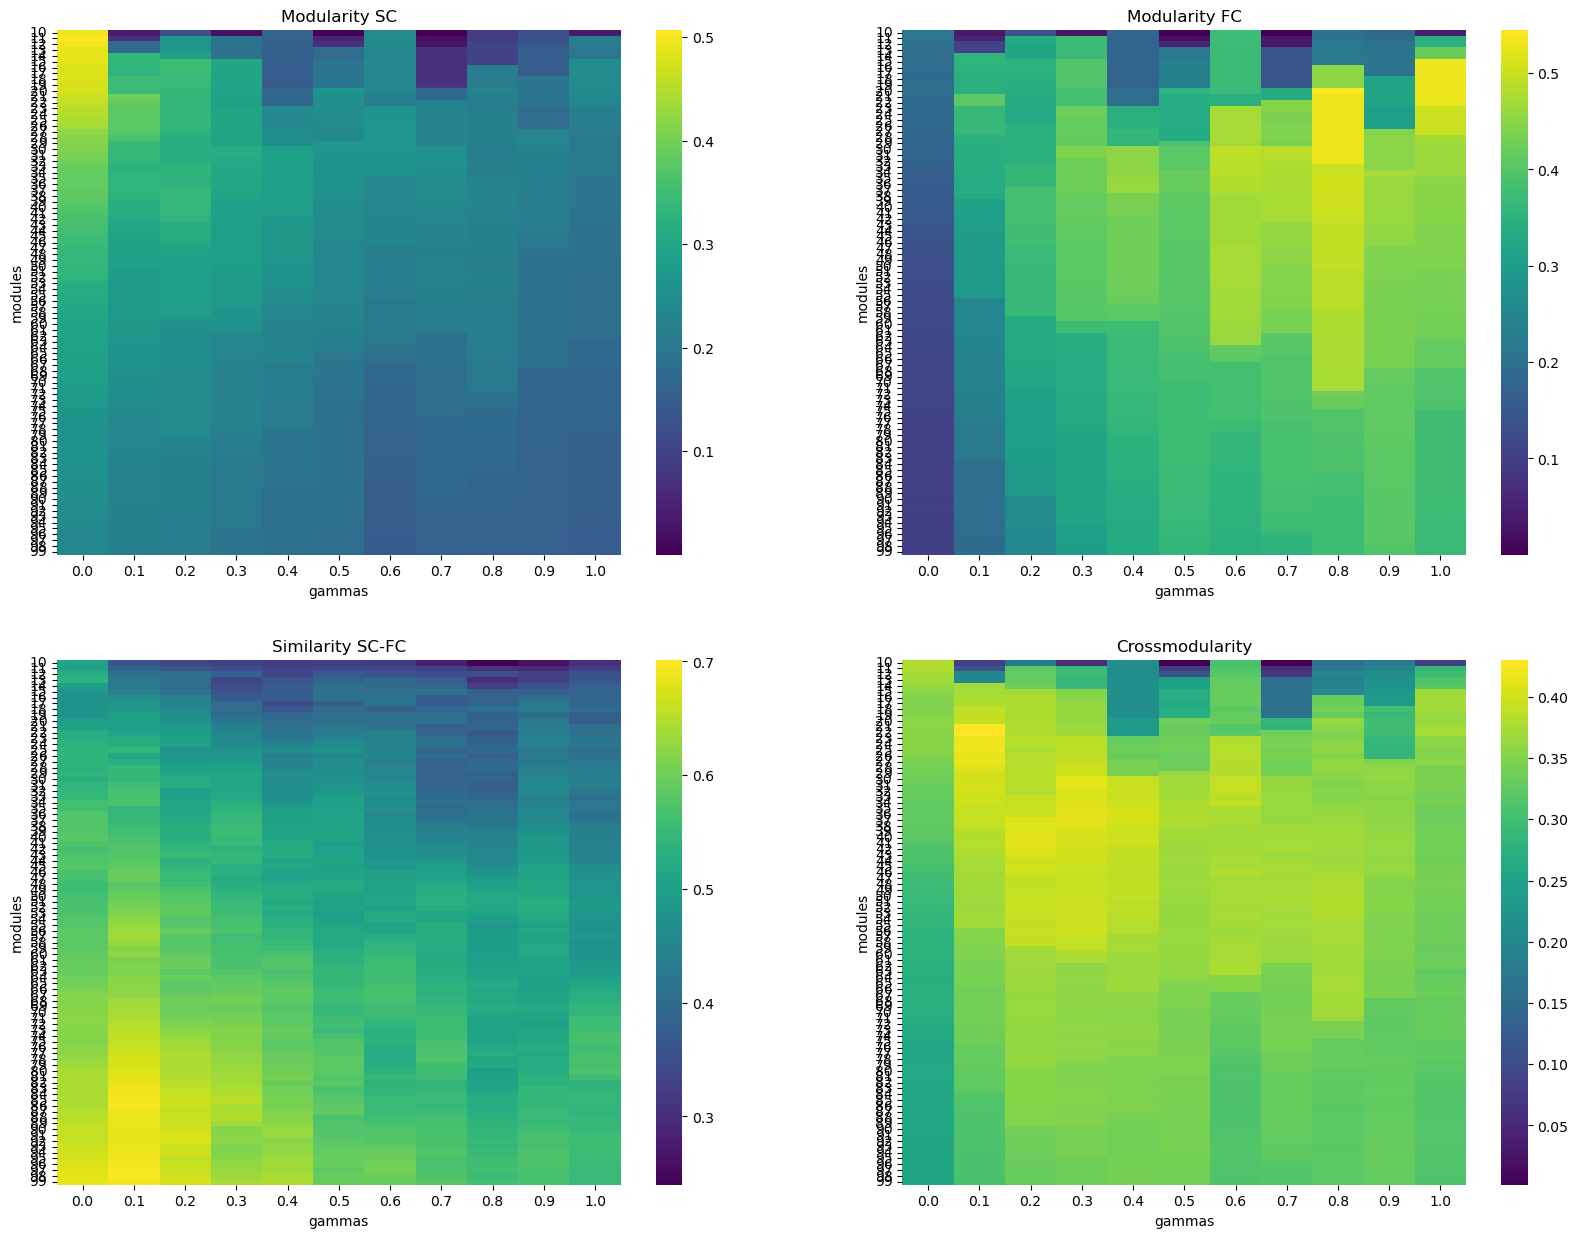

In [34]:
plot, axes = plt.subplots(2, 2, figsize=(20, 15))

h1 = sns.heatmap(mod_sc_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=False, fmt=".2f", ax=axes[0,0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("Modularity SC")

h2 = sns.heatmap(mod_fc_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=False, fmt=".2f", ax=axes[0,1])
_ = h2.set(xlabel='gammas', ylabel='modules')
_ = h2.set_title("Modularity FC")

h3 = sns.heatmap(sim_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=False, fmt=".2f", ax=axes[1,0])
_ = h3.set(xlabel='gammas', ylabel='modules')
_ = h3.set_title("Similarity SC-FC")

h4 = sns.heatmap(crossmod_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=False, fmt=".2f", ax=axes[1,1])
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

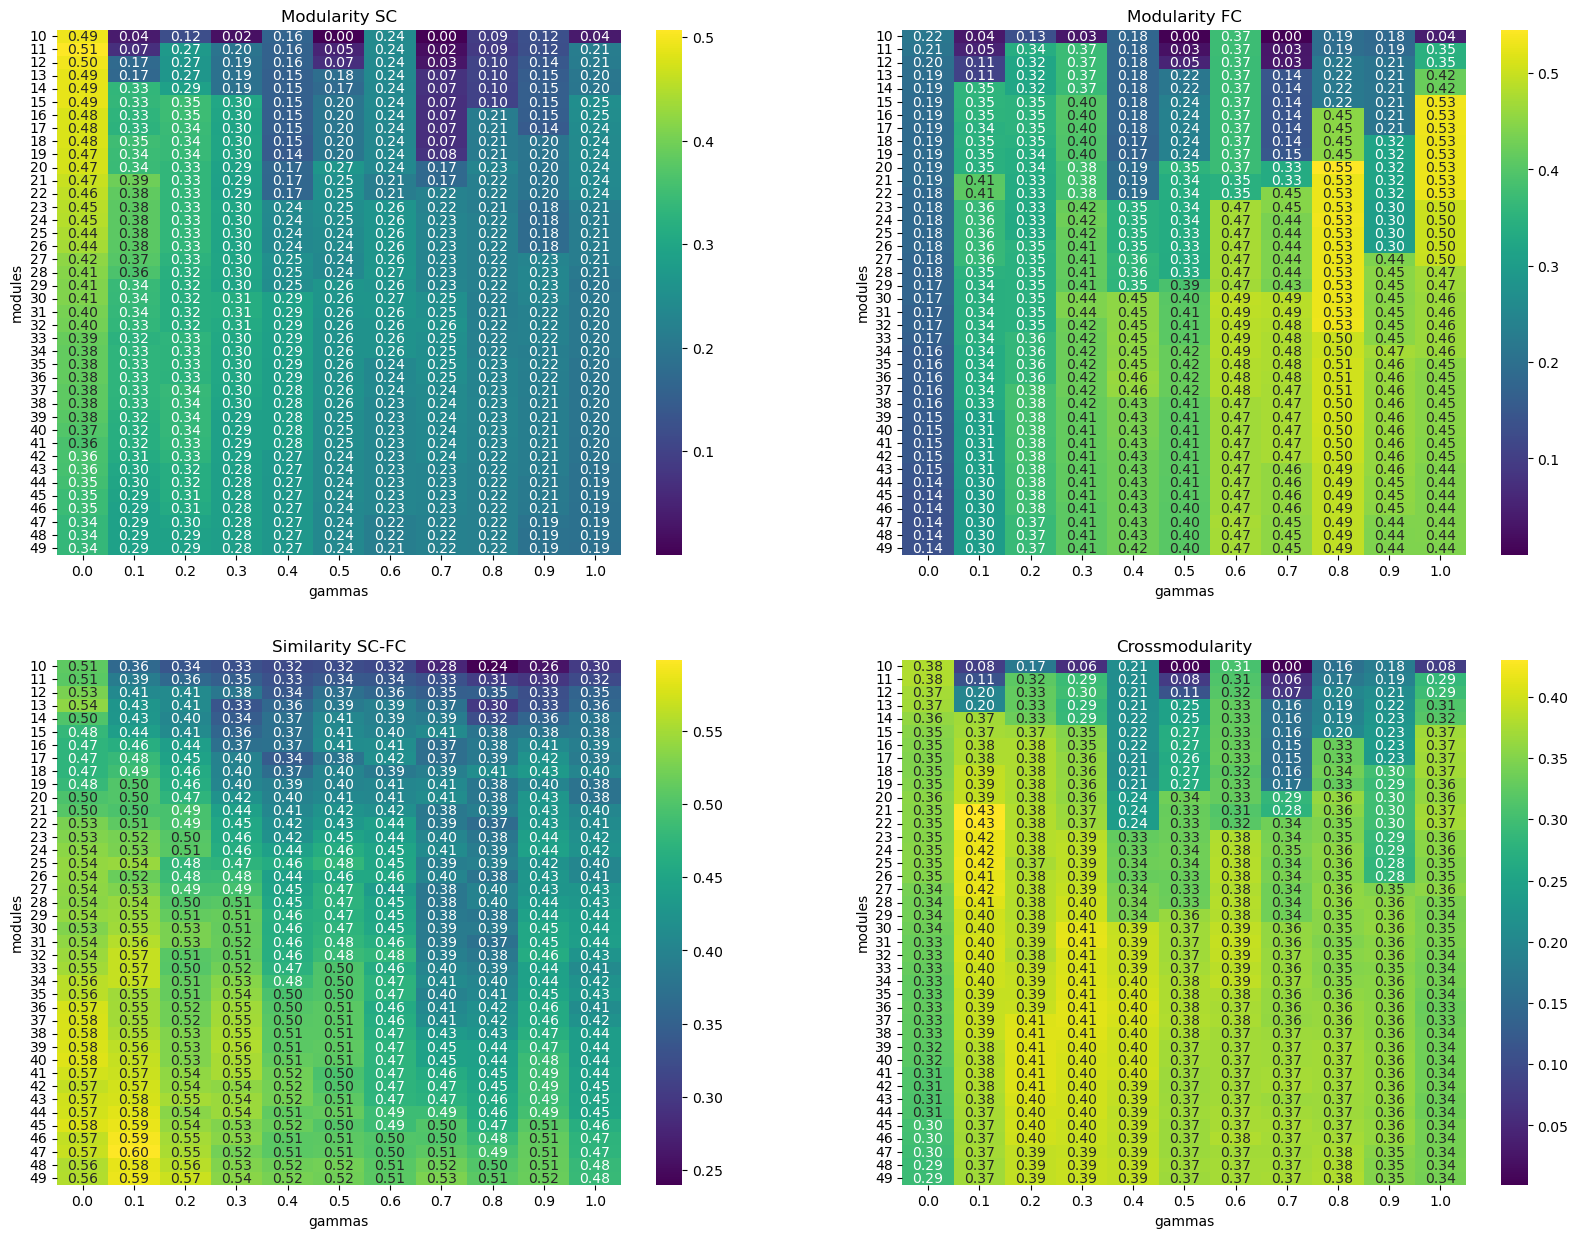

In [35]:
plot, axes = plt.subplots(2, 2, figsize=(20, 15))

h1 = sns.heatmap(mod_sc_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[0,0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("Modularity SC")

h2 = sns.heatmap(mod_fc_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[0,1])
_ = h2.set(xlabel='gammas', ylabel='modules')
_ = h2.set_title("Modularity FC")

h3 = sns.heatmap(sim_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[1,0])
_ = h3.set(xlabel='gammas', ylabel='modules')
_ = h3.set_title("Similarity SC-FC")

h4 = sns.heatmap(crossmod_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[1,1])
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

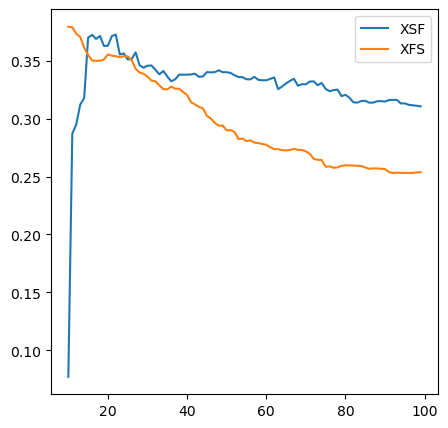

In [36]:
cmod = crossmod_gammas[:,1:]
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(np.arange(10, 100), cmod[:,10], label="XSF")
plt.plot(np.arange(10, 100), cmod[:,0], label="XFS")
plt.legend()


## Generate brain partition from atlas

In [38]:
from nilearn.plotting import plot_prob_atlas
tree = json.loads(open(os.path.join(project_path, "data", "results",
        "tree_equaldensity_bin_full_g_1.0.json")).read())
lvl = 50
level, labels = level_from_tree(tree, lvl)
atlas_name = "craddock_1795.nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()

old_rois = np.arange(1, atlas_vol.max()+1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)


atlas_moduled = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2]))
for idx,rois in enumerate(level):
    newrois = old_rois[rois]-1
    mod = get_module_vol(atlas, newrois, idx+1)
    atlas_moduled = atlas_moduled + mod

img = nib.Nifti1Image(atlas_moduled, affine=atlas.affine)
nib.save(img, os.path.join(project_path, "data", "results", "atlas_moduled_lvl_" + str(lvl) + ".nii.gz"))


## Generate AHBA matrix

In [39]:
lvl = 50
partition = os.path.join(project_path, "data", "results", "atlas_moduled_lvl_" + str(lvl) + ".nii.gz")
expresion = abagen.get_expression_data(partition)

/opt/conda/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/opt/conda/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/opt/conda/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/opt/conda/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/opt/conda/lib/python3.9/sit

<AxesSubplot:xlabel='label', ylabel='gene_symbol'>

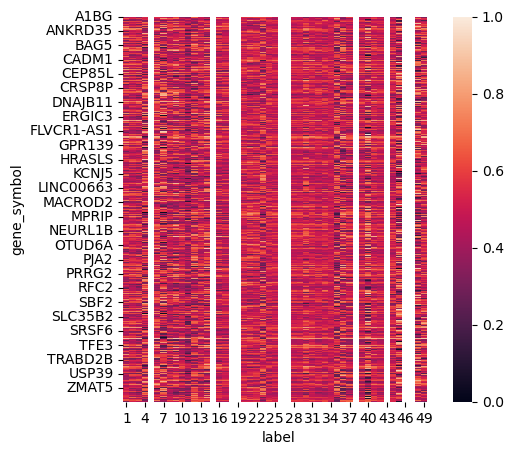

In [43]:
sns.heatmap(expresion.T)

## Fussioned degree of the 1770x1770 connectivity matrices

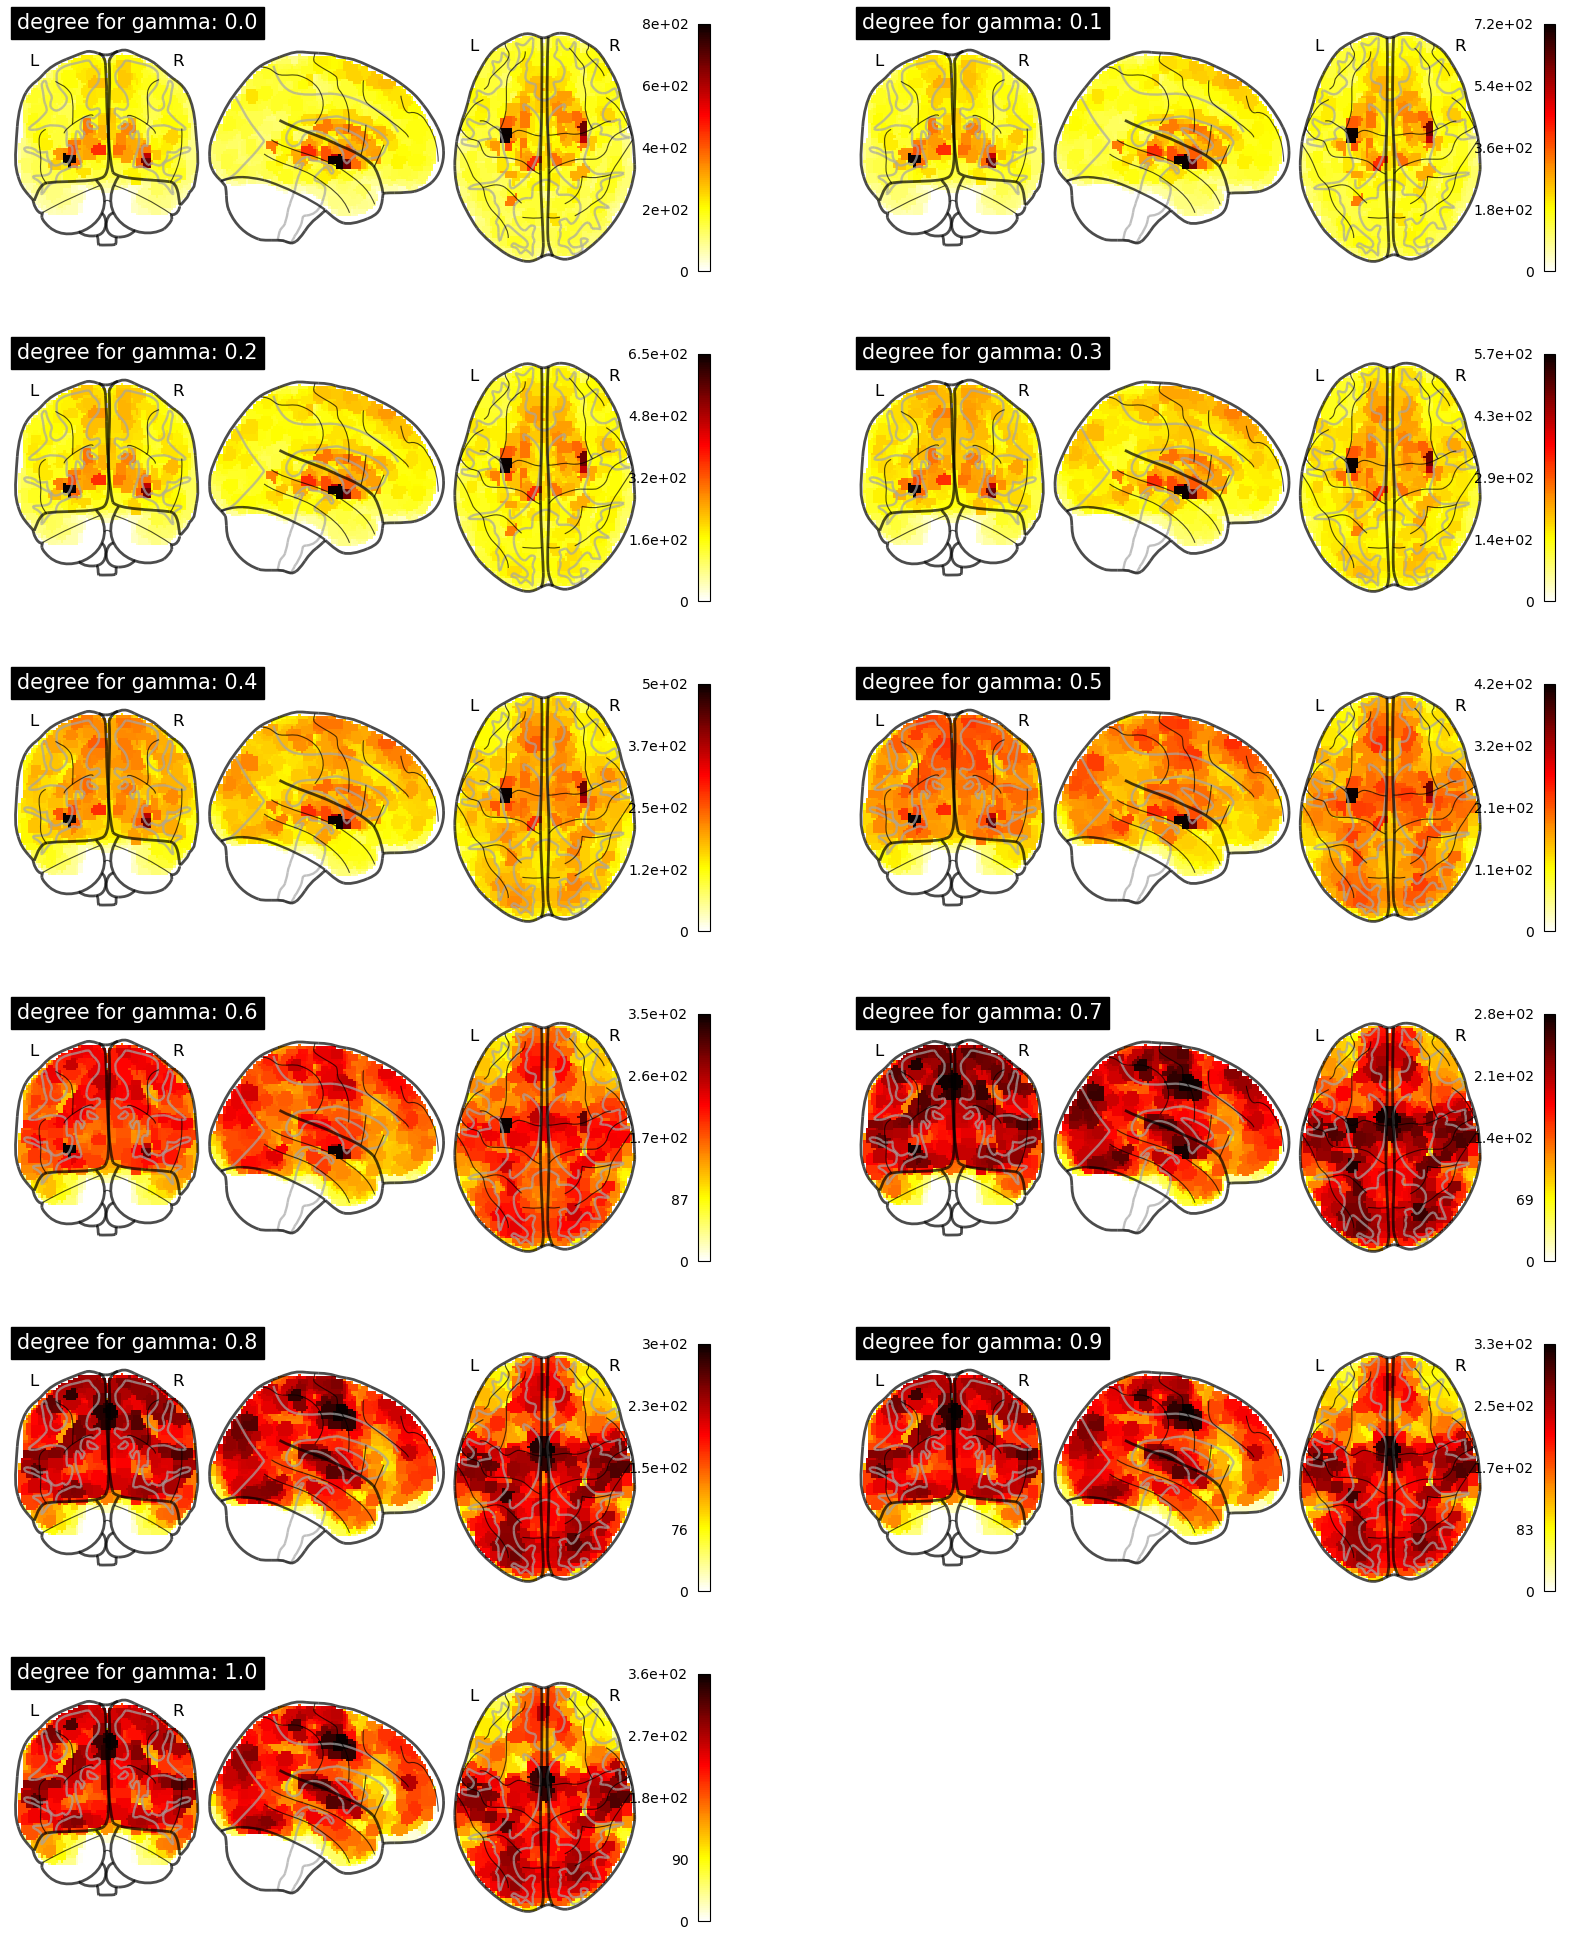

In [44]:
plt.rcParams['figure.figsize'] = [20, 25]

fig = plt.figure()

gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    
for idx,g in enumerate(gammas_vec):
    ax = fig.add_subplot(6, 2, idx+1)
    cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
    strength_fullmat = cc.sum(axis=0, dtype=float)
    deg_img = np.zeros(atlas_vol.shape)
    for roi in range(len(old_rois)):
        newrois = old_rois[roi]
        deg_img[atlas_vol == newrois] = strength_fullmat[roi]
    
    plotting.plot_glass_brain(nib.Nifti1Image(deg_img, affine=atlas.affine), 
        colorbar=True, title="degree for gamma: " + str(g), axes=ax)
    nib.save(nib.Nifti1Image(deg_img, affine=atlas.affine), os.path.join(project_path, "data", "results", "degree_g_" + str(g) + ".nii.gz"))
    


In [45]:
atlas_nonzero = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],1))

for idx, rois in enumerate(old_rois):
    atlas_nonzero[atlas_vol == rois] = idx+1

<AxesSubplot:xlabel='area', ylabel='degree'>

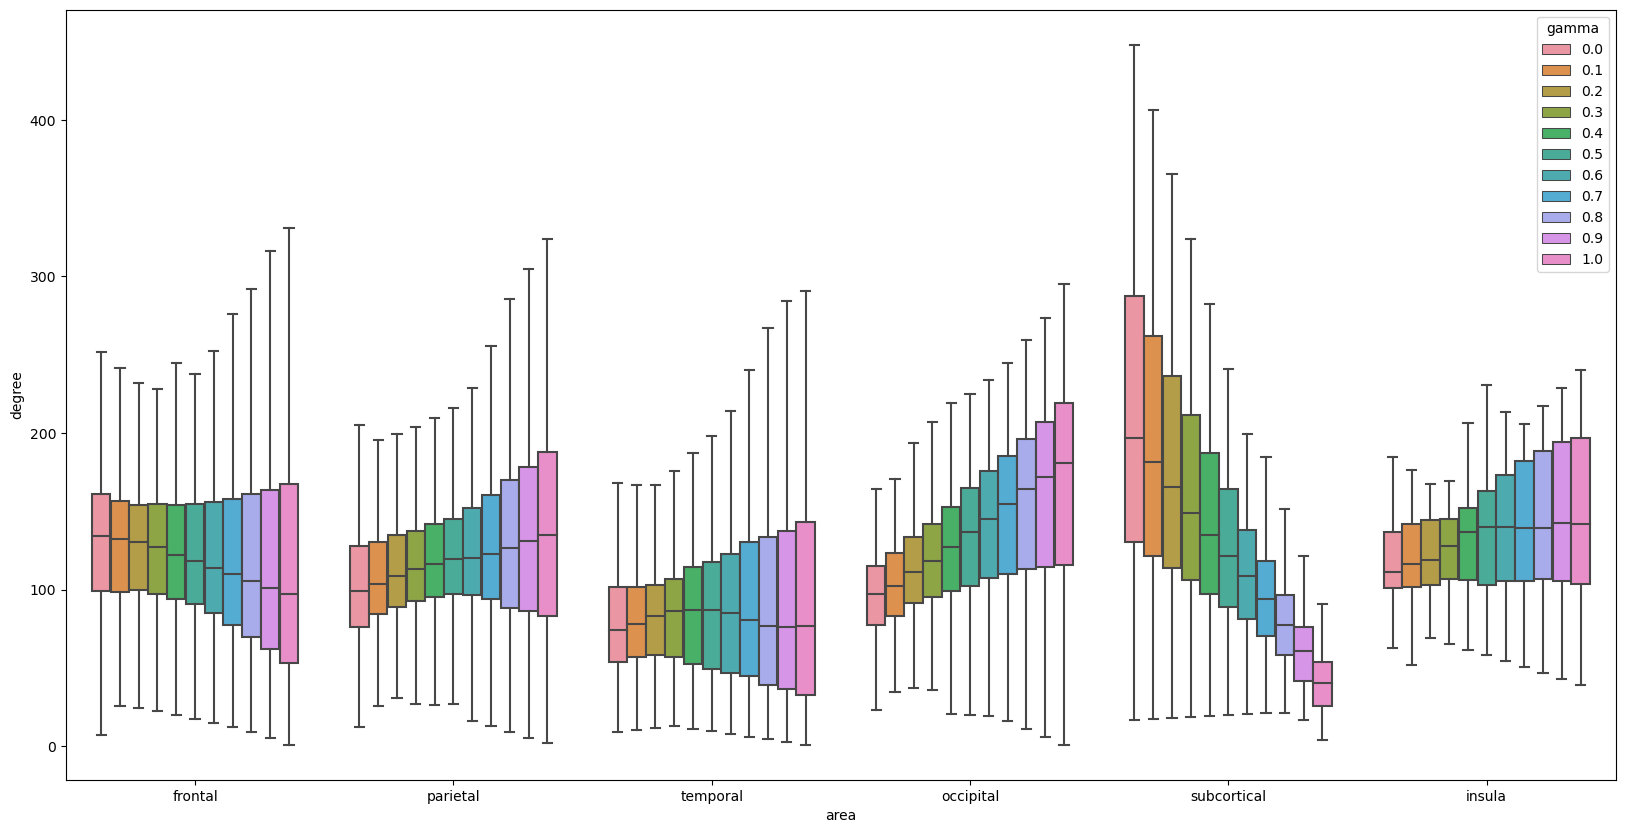

In [46]:
plt.rcParams['figure.figsize'] = [20, 10]

frontal_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Frontal_mask.nii.gz"))
insula_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Insula_mask.nii.gz"))
parietal_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Parietal_mask.nii.gz"))
temporal_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Temporal_mask.nii.gz"))
occipital_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Occipital_mask.nii.gz"))
subcortical_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", "Subcortical_mask.nii.gz"))

frois = get_atlas_rois_from_mask(frontal_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
insula = get_atlas_rois_from_mask(insula_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
parietal = get_atlas_rois_from_mask(parietal_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
temporal = get_atlas_rois_from_mask(temporal_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
occipital = get_atlas_rois_from_mask(occipital_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
subcortical = get_atlas_rois_from_mask(subcortical_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))

fig = plt.figure()
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]   

strength_vals = []
area_name = []
gamma_val = []

for idx,g in enumerate(gammas_vec):
    cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
    strength_fullmat = cc.sum(axis=0, dtype=float)

    for roi in frois:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("frontal")
        gamma_val.append(g)

    for roi in parietal:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("parietal")
        gamma_val.append(g)

    for roi in temporal:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("temporal")
        gamma_val.append(g)

    for roi in occipital:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("occipital")
        gamma_val.append(g)

    for roi in subcortical:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("subcortical")
        gamma_val.append(g)

    for roi in insula:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("insula")
        gamma_val.append(g)

df = pd.DataFrame({'degree': strength_vals, 'area': area_name, 'gamma': gamma_val})
sns.boxplot(x="area", y="degree", hue="gamma", data=df, showfliers=False)

## Module volume across the tree

In [47]:
roi_labels = pd.read_csv(os.path.join(project_path, "brain_templates", "craddock_1795_rois.csv"))
roi_labels = roi_labels.drop(zero_rows_fc)
roi_labels = roi_labels.reset_index(drop=True)
roi_labels["ROI_number"] = roi_labels.index

roi_labels.head(5)

,ROI_number,X_MNI,Y_MNI,Z_MNI,VOL,Frontal_L,Frontal_R,Insula_L,Insula_R,Occipital_L,Occipital_R,Parietal_L,Parietal_R,Subcortical_L,Subcortical_R,Temporal_L,Temporal_R
0,0,-13.6670,16.6670,-16.1520,66,1.0000,0.0000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,-46.3140,1.4118,8.8235,51,1.0000,0.0000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2,22.5930,44.4200,35.0860,81,0.0000,1.0000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,3,3.8701,-36.9870,71.5580,77,0.1039,0.8961,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,4,-17.1430,-9.8182,58.7790,77,1.0000,0.0000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [49]:

#gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]   
gammas_vec = [0.0,  0.3, 0.6, 1.0]   

levels = []
volumes = []
gv = [] 
for idx,g in enumerate(gammas_vec):
        tree = json.loads(open(os.path.join(project_path, "data", "results",
                "tree_equaldensity_bin_full_g_" + str(g) + ".json")).read())
        
        for l in range(10,100):
                level, labels = level_from_tree(tree, l)
                for module in level:
                        module_vol = (roi_labels.loc[np.array(module), "VOL"].sum()/8)
                        volumes.append(module_vol)
                        levels.append(l)
                        gv.append(g)
df = pd.DataFrame({'level': levels, 'volume': volumes, 'gamma': gv})


[(10.0, 50.0), (0.0, 2000.0)]

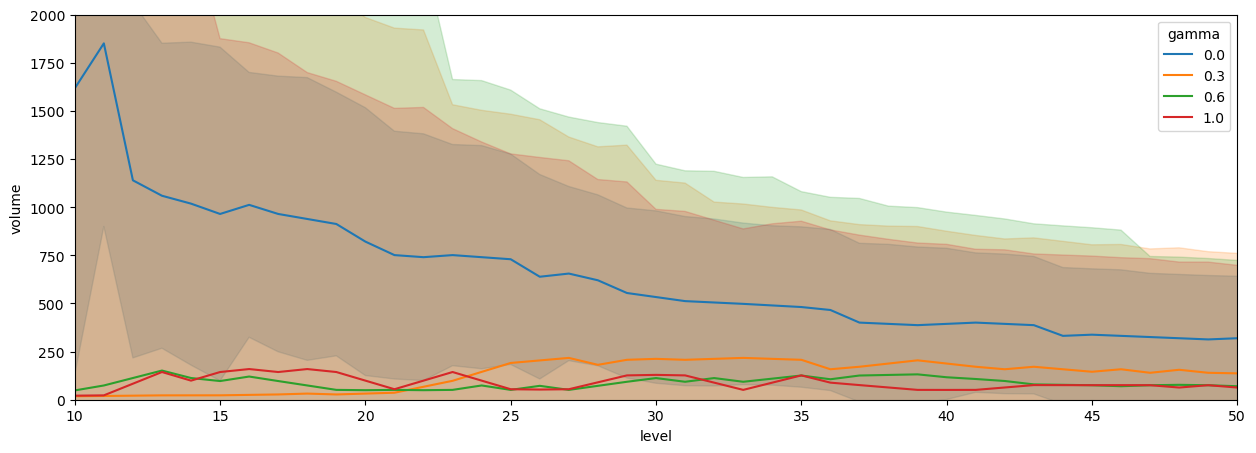

In [50]:

plt.rcParams['figure.figsize'] = [15, 5]

sns.lineplot(data=df, x="level", y="volume", hue="gamma", palette="tab10", ci="sd", estimator=np.median).set(xlim=(10, 50),ylim=(0, 2000))




